# Lab: Transformer in Practice


We train ``nn.TransformerEncoder`` model on a
language modeling task. The language modeling task is to assign a
probability for the likelihood of a given word (or a sequence of words) to follow a sequence of words.

A sequence of tokens are passed to the embedding
layer first, followed by a positional encoding layer to account for the order
of the word (see the rest of the lab for more details). The
``nn.TransformerEncoder`` consists of multiple layers of
[``nn.TransformerEncoderLayer``](https://pytorch.org/docs/master/nn.html?highlight=transformerencoderlayer#torch.nn.TransformerEncoderLayer).

Along with the input sequence, a square
attention mask is required because the self-attention layers in
``nn.TransformerEncoder`` are only allowed to attend the earlier positions in
the sequence. For the language modeling task, any tokens on the future
positions should be masked.

To have the actual words, the output
of ``nn.TransformerEncoder`` model is sent to the final Linear
layer, which is followed by a log-Softmax function.




In [ ]:
%matplotlib inline

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
#Colab
#!pip install torchtext
#conda
#conda install -c pytorch torchtext

In [ ]:
import torchtext
print(torchtext.__version__)

0.8.0a0+0f911ec


## Define the model
----------------




#### First steps with the transformer layers

"TransformerEncoderLayer" is made up of self-attn and feedforward network. This standard encoder layer is based on the paper “Attention Is All You Need”.

"dim_feedforward" is the dimension of the hidden layer in the feedforward neural network.

More details on them [here](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer)

In [ ]:
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8, dim_feedforward=1000)
src = torch.rand(10, 32, 512)
out = encoder_layer(src)
print(src.shape)
print(out.shape)

torch.Size([10, 32, 512])
torch.Size([10, 32, 512])


We create a transformer as a stack of encoder layers. "TransformerEncoder" is a stack of "num_layers" encoder layers.

More details on them [here](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder)

In [ ]:
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
src = torch.rand(10, 32, 512)
out = transformer_encoder(src)
print(src.shape)
print(out.shape)

torch.Size([10, 32, 512])
torch.Size([10, 32, 512])


#### __init__ parameters:
- ntoken: the size of vocabulary (number of different tokens),
- ninp: common dimension of each element of the input sequence,
- nhead: number of heads in the multi-head attention,
- nhid: number of neurons in the feedforward neural network,
- nlayers: number of encoder layers in the tranformer's encoder,
- dropout: probability of dropout

___________________________________________________________________

### Question: explain how the "forward" function works? What is the role of the mask "src_mask"?

- the input element (src) is embedded as a numeric vector ("encoder") with a scaling factor (squareroot of its dimension)
- the embedded element is jointly encoded with its position ("pos_encoder")
- the input element is processed by the transformer's encoder ("transformer_encoder"). It is a TransformerEncoder with a stack of N encoder layers
- the outout is produced by the decoder ("decoder").


In [ ]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    # Generate an upper triangular mask: lower part is -inf and upper part is 0.0
    def generate_square_subsequent_mask(self, sz):
        # torch.triu returns a copy of a matrix with the elements below the k-th diagonal zeroed.
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src) # add the positional encoding (pe) to src: src <- src + pe
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

### Positional Encoding

``PositionalEncoding`` module injects some information about the
relative or absolute position of the tokens in the sequence. The
positional encodings have the same dimension as the embeddings so that
the two can be summed. Here, we use ``sine`` and ``cosine`` functions of
different frequencies.




#### the class __PositionalEncoding__ adds the sine or cosine components to the inputs

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

#### Response:

The mask __scr_mask__ prevents the encoder to use the information in the future. Hence, the prediction is just based on the past information.

This masking, combined with fact that the targets are offset by one position, ensures that the predictions for position i can depend only on the known outputs at positions less than i.

Technically, if a FloatTensor is provided as the mask, it will be added to the attention weight.

See details [here](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)

In [ ]:
# Test the function to generate a mask
tmp_model = TransformerModel(10, 4, 4, 4, 2, 0.5) # just a model to study the mak. The parameters of the model have no meaning.
src_mask_dim5 = tmp_model.generate_square_subsequent_mask(5)
print(src_mask_dim5)

print(src_mask_dim5.type())

tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])
torch.FloatTensor


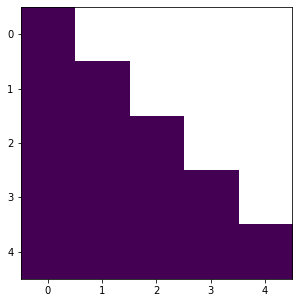

In [ ]:
# Print the mask as an image
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.imshow(src_mask_dim5)
plt.show()

_____________________________________________________________________________

Load and batch data
-------------------




This tutorial uses ``torchtext`` to generate Wikitext-2 dataset. The
vocab object is built based on the train dataset and is used to numericalize
tokens into tensors. Starting from sequential data, the ``batchify()``
function arranges the dataset into columns, trimming off any tokens remaining
after the data has been divided into batches of size ``batch_size``.
For instance, with the alphabet as the sequence (total length of 26)
and a batch size of 4, we would divide the alphabet into 4 sequences of
length 6:

\begin{align}\begin{bmatrix}
  \text{A} & \text{B} & \text{C} & \ldots & \text{X} & \text{Y} & \text{Z}
  \end{bmatrix}
  \Rightarrow
  \begin{bmatrix}
  \begin{bmatrix}\text{A} \\ \text{B} \\ \text{C} \\ \text{D} \\ \text{E} \\ \text{F}\end{bmatrix} &
  \begin{bmatrix}\text{G} \\ \text{H} \\ \text{I} \\ \text{J} \\ \text{K} \\ \text{L}\end{bmatrix} &
  \begin{bmatrix}\text{M} \\ \text{N} \\ \text{O} \\ \text{P} \\ \text{Q} \\ \text{R}\end{bmatrix} &
  \begin{bmatrix}\text{S} \\ \text{T} \\ \text{U} \\ \text{V} \\ \text{W} \\ \text{X}\end{bmatrix}
  \end{bmatrix}\end{align}

These columns are treated as independent by the model, which means that
the dependence of ``G`` and ``F`` can not be learned, but allows more
efficient batch processing.




#### What is TorchText?

TorchText is a pytorch package that contains different data processing methods as well as popular NLP datasets. According to the official PyTorch documentation, torchtext has 4 main functionalities: data, datasets, vocab, and utils. Data is mainly used to create custom dataset class, batching samples etc. Datasets consists of the various NLP datasets from sentiment analysis to question answering. Vocab covers different methods of processing text and utils consists of additional helper functions.

#### Warning: path to access the dataset

The following variables "from_path" and "to_path" are necessary to store the dataset.

They are defined for Google colab.

You must change them if you are using your personal Python installation.

In [ ]:
# Google Colab
#from_path = '/content/sample_data/wikitext-2-v1.zip'
#to_path = '/content/sample_data/'

# Personal laptop
from_path = './wikitext-2-v1.zip'
to_path = './'

Download and preprocess the dataset.

In [ ]:
import io
import torch
from torchtext.utils import download_from_url, extract_archive
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

url = 'https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip'
download_from_url(url, from_path)
test_filepath, valid_filepath, train_filepath = extract_archive(from_path, to_path)



Print the file paths

In [ ]:
print(test_filepath)
print(valid_filepath)
print(train_filepath)

./wikitext-2/wiki.test.tokens
./wikitext-2/wiki.valid.tokens
./wikitext-2/wiki.train.tokens


### Question: what is the role of "tokenizer".

The function get_tokenizer("basic_english") generate a tokenizer function for a string sentence. It is dedicated to english language.

A tokenizer deels with the [tokenization](https://www.analyticsvidhya.com/blog/2020/05/what-is-tokenization-nlp/). Tokenization is a way of separating a piece of text into smaller units called tokens.

The following cell gives an example.

In [ ]:
tokenizer = get_tokenizer("basic_english")
tokens = tokenizer("You can now install TorchText using pip!")
tokens

['you', 'can', 'now', 'install', 'torchtext', 'using', 'pip', '!']

Just see a part of the raw text to understand how the text will be preprocess.

In [ ]:
raw_text_iter = iter(io.open(valid_filepath, encoding="utf8"))

#Line breaks in text are generally represented as:
#
#\r\n - on a windows computer
#\r - on an Apple computer
#\n - on Linux

for number in range(4):
    print("Item " + str(number))
    item = next(raw_text_iter)
    print(item)
    item = item.replace("\n","")
    print(item)
    print(type(item))
    print(tokenizer(item))

Item 0
 

 
<class 'str'>
[]
Item 1
 = Homarus gammarus = 

 = Homarus gammarus = 
<class 'str'>
['=', 'homarus', 'gammarus', '=']
Item 2
 

 
<class 'str'>
[]
Item 3
 Homarus gammarus , known as the European lobster or common lobster , is a species of <unk> lobster from the eastern Atlantic Ocean , Mediterranean Sea and parts of the Black Sea . It is closely related to the American lobster , H. americanus . It may grow to a length of 60 cm ( 24 in ) and a mass of 6 kilograms ( 13 lb ) , and bears a conspicuous pair of claws . In life , the lobsters are blue , only becoming " lobster red " on cooking . Mating occurs in the summer , producing eggs which are carried by the females for up to a year before hatching into <unk> larvae . Homarus gammarus is a highly esteemed food , and is widely caught using lobster pots , mostly around the British Isles . 

 Homarus gammarus , known as the European lobster or common lobster , is a species of <unk> lobster from the eastern Atlantic Ocean , Me

### Question: what is the role of "vocab"?

In [ ]:
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer,
                                      iter(io.open(train_filepath,
                                                   encoding="utf8"))))

36718lines [00:01, 24055.30lines/s]


It defines a vocabulary object that will be used to numericalize a field.

"vocab" is basically a dictionary (the dictionary is the field "stoi")
The dictionary encodes a word as a number.
There are two special characters:

pad_token – The string token used as padding. Default: “<pad>”.
    
unk_token – The string token used to represent OOV words. Default: “<unk>”.
    
Padding can be useful when we want to process some sentences with a constant length. The pad symbols is added to adjust the sentence length.
    
The following cell illustrates the behavior of "vocab" with a given itemized text.

In [ ]:
mytext = ['known', 'the', 'european']
vocab_toy = build_vocab_from_iterator(map(tokenizer,iter(mytext)))

# Print the encoded items
print(vocab_toy.itos)
# Print the dictionary
print(vocab_toy.stoi)
# Print all the numerical codes
print([vocab_toy[w] for w in vocab_toy.itos])

# Test with some items (unknown or known)
print(vocab_toy['<unk>'])
print(vocab_toy['<pad>'])
print(vocab_toy['Polytech'])
print(vocab_toy['the'])

3lines [00:00, 10313.86lines/s]

['<unk>', '<pad>', 'european', 'known', 'the']
defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7ff94c167b80>>, {'<unk>': 0, '<pad>': 1, 'european': 2, 'known': 3, 'the': 4})
[0, 1, 2, 3, 4]
0
1
0
4


### Question: what is the role of the function "data_process"?

It transforms the raw text (english words) into a tensor of numbers.
The raw text is decomposed into tokens with "tokenizer" defined above.
The numerical encoding of a token is then obtained with "vocab" defined above.

In [ ]:
def data_process(raw_text_iter):
  data = [torch.tensor([vocab[token] for token in tokenizer(item)],
                       dtype=torch.long) for item in raw_text_iter]
  return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

train_data = data_process(iter(io.open(train_filepath, encoding="utf8")))
val_data = data_process(iter(io.open(valid_filepath, encoding="utf8")))
test_data = data_process(iter(io.open(test_filepath, encoding="utf8")))



In [ ]:
raw_text_iter=iter(io.open(train_filepath, encoding="utf8"))
nb_item = 0
for item in raw_text_iter:
    print('-' * 40)
    print("Item n°"+str(nb_item))
    print(item)
    for token in tokenizer(item):
        print(token)

    # We just read 4 items (the four first lines)
    if nb_item == 3:
        break
    else:
        nb_item += 1

----------------------------------------
Item n°0
 

----------------------------------------
Item n°1
 = Valkyria Chronicles III = 

=
valkyria
chronicles
iii
=
----------------------------------------
Item n°2
 

----------------------------------------
Item n°3
 Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . <unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . 

senjō
no
valkyria
3
<unk>
chronicles
(
j

In [ ]:
print(type(train_data))
# The length of train_data corresponds to the sequence of items that have been encoded.
print(train_data.shape)
# Print the 10 first first items as numbers
print(train_data[0:10])

<class 'torch.Tensor'>
torch.Size([2049990])
tensor([   10,  3850,  3870,   882,    10, 20001,    84,  3850,    89,     0])


We reduce the size of the dataset to get results faster

In [ ]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)
train_data = train_data[0:10000]
val_data = val_data[0:10000]
test_data = test_data[0:10000]

torch.Size([2049990])
torch.Size([214417])
torch.Size([241859])


Use a GPU if possible

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Create the batches

### Question: what is the physical meaning (with respect to the raw text) of a batch?

### Response:
Each column corresponds to a batch.
The successive elements of a column correspond to the successive elements of the input 1D tensor.

In [ ]:
### Response:
#import numpy as np
#A = torch.tensor(np.array([[1, 2, 3], [4, 5, 6]]))
# The following example shows how "batchify" is reordering a 1D tensor
A = torch.tensor([1, 2, 3, 4, 5, 6])
print(A)
B = A.view(2, -1).t().contiguous()
print(B)

tensor([1, 2, 3, 4, 5, 6])
tensor([[1, 4],
        [2, 5],
        [3, 6]])


In [ ]:
def batchify(data, bsz):
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz # number of elements in a batch
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    # "contiguous()" returns a contiguous in memory tensor containing the same data as self tensor.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

batch_size = 20 # number of batches
eval_batch_size = 10

import copy
train_data_initial = copy.deepcopy(train_data)

train_data = batchify(train_data, batch_size)
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

In [ ]:
print(train_data.shape)
print(val_data.shape)

torch.Size([500, 20])
torch.Size([1000, 10])


## Functions to generate input and target sequence
--------------------------------------------------

``get_batch()`` function generates the input and target sequence for
the transformer model. It subdivides the source data into chunks of
length ``bptt``. For the language modeling task, the model needs the
following words as ``Target``. For example, with a ``bptt`` value of 2,
we’d get the following two Variables for ``i`` = 0:

![](https://pytorch.org/tutorials/_images/transformer_input_target.png)

It means that from each column of "Input" (a column is a sequence), we want to predict the column of "Target".





### Question: what is returned by "get_batch"?

### Response:
"get_batch" returns a kind of minibatch: each "data" returned by this function corresponds to a certain number of rows of each batch. The number of colums is unchanged (the number of batch remains constant).

The "target" is a minibatch with one row shift "near the future" compared to the "data" minibatch.

In [ ]:
bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

In [ ]:
### Response:
# Print 3 minibatches to show the link between the data and the targets
for batch, i in enumerate(range(0, 3*bptt, bptt)):
    data, targets = get_batch(train_data, i)
    print(data.shape)
    print(targets.shape)
    print(data[:,0])
    print(targets.view(35, 20)[:,0])


torch.Size([35, 20])
torch.Size([700])
tensor([   10,  3850,  3870,   882,    10, 20001,    84,  3850,    89,     0,
         3870,    22,   781, 28781,     3,  6183,     4,  3850,     5,     2,
         5024,    89,    21,     3,  1838,  1019,     8,    15,  3850,  3870,
          882,   630,   977,     3,    24])
tensor([ 3850,  3870,   882,    10, 20001,    84,  3850,    89,     0,  3870,
           22,   781, 28781,     3,  6183,     4,  3850,     5,     2,  5024,
           89,    21,     3,  1838,  1019,     8,    15,  3850,  3870,   882,
          630,   977,     3,    24,     9])
torch.Size([35, 20])
torch.Size([700])
tensor([    9,  5791,   300,    13,   576,   233,    68,   453,    20, 13723,
            6,   758,     4,  2501,    18,     2,  1768,  5638,     4,   156,
            7,   247,   355,     7,   977,     3,    25,    24,     2,   238,
           68,     7,     2,  3850,    94])
tensor([ 5791,   300,    13,   576,   233,    68,   453,    20, 13723,     6,
          

Initiate an instance
--------------------




The model is set up with the hyperparameter below. The vocab size is
equal to the length of the vocab object.




In [ ]:
ntokens = len(vocab.stoi) # the size of vocabulary
emsize = 200 # embedding dimension (it corresponds to "ninp")
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

Run the model
-------------




[``CrossEntropyLoss``](https://pytorch.org/docs/master/nn.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss) is applied to track the loss and
[``SGD``](https://pytorch.org/docs/master/optim.html?highlight=sgd#torch.optim.SGD)
implements stochastic gradient descent method as the optimizer.

The initial learning rate is set to 5.0. [``StepLR``](https://pytorch.org/docs/master/optim.html?highlight=steplr#torch.optim.lr_scheduler.StepLR) is
applied to adjust the learn rate through epochs.

During the
training, we use
[``nn.utils.clip_grad_norm_``](https://pytorch.org/docs/master/nn.html?highlight=nn%20utils%20clip_grad_norm#torch.nn.utils.clip_grad_norm_)
function to scale all the gradient together to prevent exploding.




### Question: what is the role of "StepLR"?

### Response:
It decays the learning rate of each parameter group by gamma every step_size epochs.

In [ ]:
criterion = nn.CrossEntropyLoss()
lr = 5.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

Perplexity is an evaluation criterion that has been well studied over the past few years

Perplexity, called ppl in the next cell, is the exponentiation of the average cross entropy of a corpus (Mikolov et al., 2011).

### Question: what is the role of "torch.nn.utils.clip_grad_norm_"?

In [ ]:
import time

log_interval = 20

def train():
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    # Loop over the training batches
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        #print(data.shape)
        optimizer.zero_grad()
        if data.size(0) != bptt:
            src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()

        # Print a summary each log_interval iterations
        # The summary is focused on the loss
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval # compute the current loss over the log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_last_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

The next function evaluates a trained neural network

In [ ]:
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            if data.size(0) != bptt:
                src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
            output = eval_model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)

Loop over epochs. Save the model if the validation loss is the best
we've seen so far. Adjust the learning rate after each epoch.



In [ ]:
best_val_loss = float("inf")
epochs = 3 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train() # train a model for one epoch
    val_loss = evaluate(model, val_data) # evaluate the performance of the trained model
    # Print the performance of the trained model on the evaluation dataset
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    # Keep the model if the loss decreases
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step() # Update the scheduler step with "StepLR" at each epoch

-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 11.16s | valid loss  8.76 | valid ppl  6372.34
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 10.99s | valid loss  8.23 | valid ppl  3758.54
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 10.37s | valid loss  9.90 | valid ppl 19894.84
-----------------------------------------------------------------------------------------


Evaluate the model with the test dataset
-------------------------------------

Apply the best model to check the result with the test dataset.



In [ ]:
test_loss = evaluate(best_model, test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

| End of training | test loss  9.94 | test ppl 20711.95
